In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from scipy.stats import chi2_contingency, linregress, pearsonr, spearmanr, ks_2samp 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    mean_squared_error, 
    r2_score
)
from sklearn.model_selection import train_test_split
import requests
import pymysql
import json
import urllib


ygo = pd.read_csv('ygocards.csv')
#If I needed to import anything at any time in this project I just put it up here so I won't have
# to import stuff I've already imported, I just scroll up and see.
# I also just threw every library I knew on here beforehand so some of them I won't even use. I'll clean it 
# up before the final submission, I just like to keep stuff "just in case", and some stuff I DID use, but might've gotten rid of 

In [3]:
# Filter only for TCG cards (removing Asian market because it is annoying with a language barrier and a different ban list)
#OCG is a couple months ahead of the TCG and operates on a different language AND ban list so it's not good to combine- too many double-entries
ygo_tcg = ygo[ygo['formats'].str.contains("TCG", na=False)]

# Verify filter actually works
print(f"Original dataset size: {len(ygo)}") # f strings my beloved :)
print(f"Filtered TCG dataset size: {len(ygo_tcg)}")


Original dataset size: 13281
Filtered TCG dataset size: 12741


In [4]:
# Describe statistics for numerical columns in TCG
numerical_cols = ['atk', 'def', 'level', 'scale', 'linkval', 'views', 'viewsweek', 'upvotes', 'downvotes']
numerical_stats = ygo_tcg[numerical_cols].describe()
print("Descriptive statistics for TCG cards (numerical data):")
print(numerical_stats)


Descriptive statistics for TCG cards (numerical data):
               atk          def        level       scale     linkval  \
count  8277.000000  7872.000000  7872.000000  343.000000  405.000000   
mean   1499.835689  1265.485264     4.639482    4.405248    2.422222   
std     951.285194   876.262169     2.414669    3.026525    0.981008   
min       0.000000     0.000000     0.000000    0.000000    1.000000   
25%     800.000000   500.000000     3.000000    2.000000    2.000000   
50%    1500.000000  1200.000000     4.000000    4.000000    2.000000   
75%    2200.000000  2000.000000     6.000000    7.000000    3.000000   
max    5000.000000  5000.000000    13.000000   13.000000    6.000000   

              views     viewsweek       upvotes     downvotes  
count  1.274100e+04  12741.000000  12741.000000  12741.000000  
mean   1.234412e+05      2.976375      6.883133      1.376737  
std    3.027226e+05     10.618287     37.304676      6.688691  
min    0.000000e+00      0.000000      0

In [5]:
# Describe statistics for categorical columns in TCG
categorical_cols = ['type', 'race', 'attribute', 'archetype', 'ban_tcg']
for col in categorical_cols:
    print(f"\nUnique value counts for {col} in TCG dataset:") # I've said it before... I'll say it again... I <3 F-Strings
    print(ygo_tcg[col].value_counts())


Unique value counts for type in TCG dataset:
type
Effect Monster                     4665
Spell Card                         2553
Trap Card                          1911
XYZ Monster                         510
Normal Monster                      503
Fusion Monster                      465
Tuner Monster                       458
Synchro Monster                     407
Link Monster                        405
Pendulum Effect Monster             268
Flip Effect Monster                 183
Ritual Effect Monster               116
Gemini Monster                       45
Synchro Tuner Monster                40
Union Effect Monster                 36
Pendulum Normal Monster              36
Spirit Monster                       33
Token                                27
Toon Monster                         17
Ritual Monster                       15
Pendulum Effect Fusion Monster       11
Normal Tuner Monster                 10
XYZ Pendulum Effect Monster          10
Pendulum Tuner Effect Monster

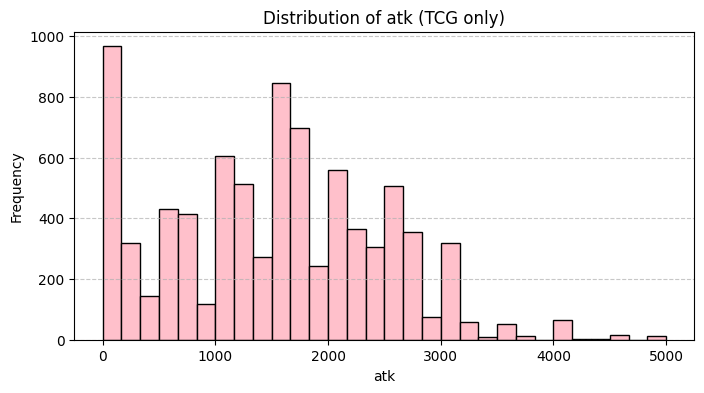

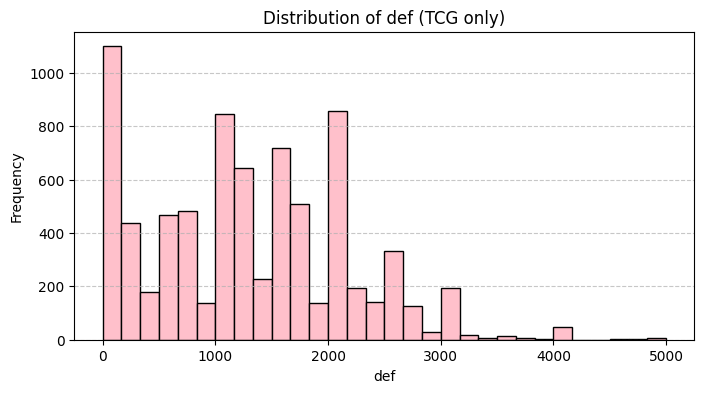

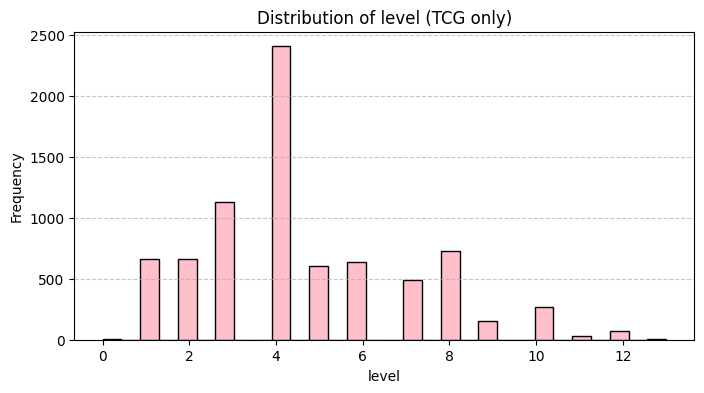

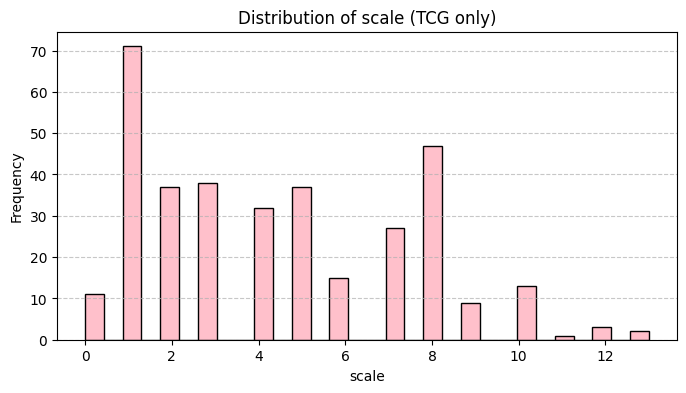

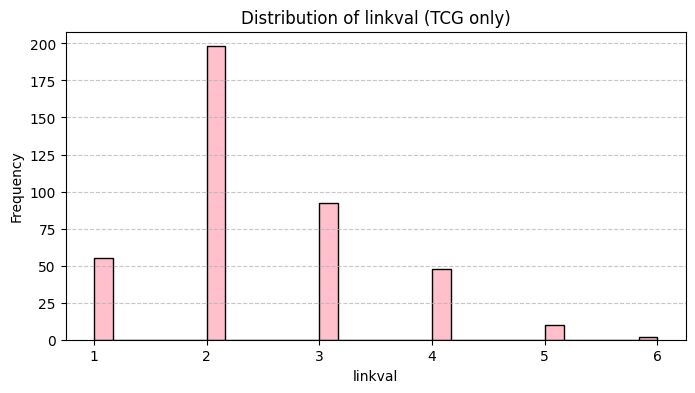

In [6]:
# Columns to exclude because they're pretty much useless for this
exclude_cols = ['viewsweek', 'upvotes', 'downvotes', 'views']

# Loop through numerical columns, excluding said useless stuff, for histograms (I'm lazy)
for col in [c for c in numerical_cols if c not in exclude_cols]: 
    if ygo_tcg[col].notnull().sum() > 0:  # Skip columns w/ no data
        plt.figure(figsize=(8, 4))
        plt.hist(ygo_tcg[col].dropna(), bins=30, color='pink', edgecolor='black')
        plt.title(f"Distribution of {col} (TCG only)") # f-string :)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


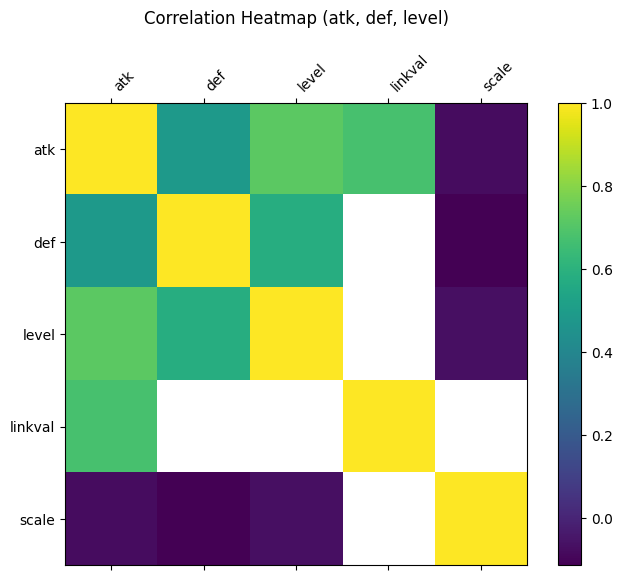

In [7]:
# Correlation matrix for atk, def, and level
corr_matrix = ygo_tcg[['atk', 'def', 'level', 'linkval', 'scale']].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr_matrix)
fig.colorbar(cax)

# Add labels
columns = ['atk', 'def', 'level', 'linkval', 'scale']
ax.set_xticks(range(len(columns)))
ax.set_yticks(range(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='left')
ax.set_yticklabels(columns)

plt.title("Correlation Heatmap (atk, def, level)", pad=20)
plt.show()


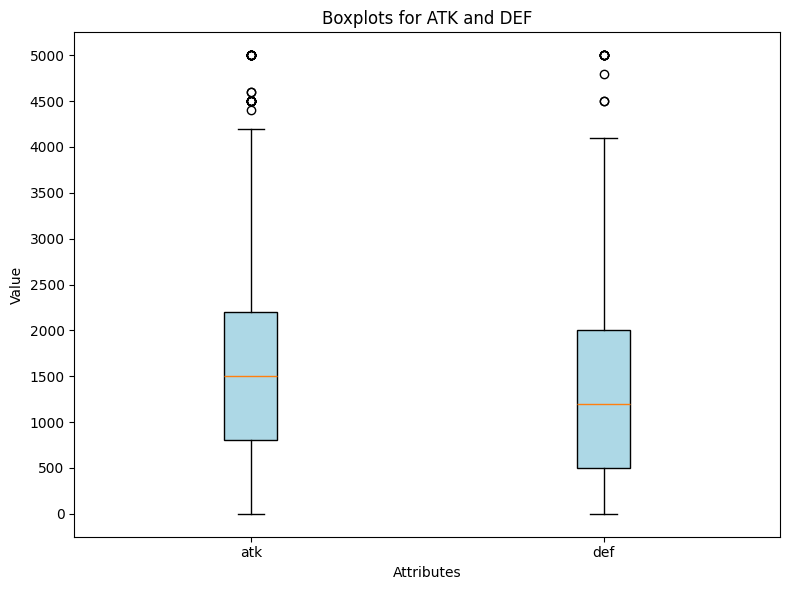

In [8]:
# Boxplots for atk and def
fig, ax = plt.subplots(figsize=(8, 6))

# Plot boxplots for atk and def
ax.boxplot(
    [ygo_tcg['atk'].dropna(), ygo_tcg['def'].dropna()],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'), 
    tick_labels=['atk', 'def']  # Labels for the two plots
)

# Set custom y-ticks to increment by 500 instead of 1000 so I don't have to squint
max_value = max(ygo_tcg[['atk', 'def']].max()) # Find the highest value in ATK / DEF (5,000 for each)
yticks = range(0, int(max_value) + 500, 500)
ax.set_yticks(yticks)
# The max values are 5000/5000, that's just basic game knowledge but I figured I'd include the code anyways for funsies

# Add title and labels
ax.set_title("Boxplots for ATK and DEF")
ax.set_ylabel("Value")
ax.set_xlabel("Attributes")
plt.tight_layout()
plt.show()


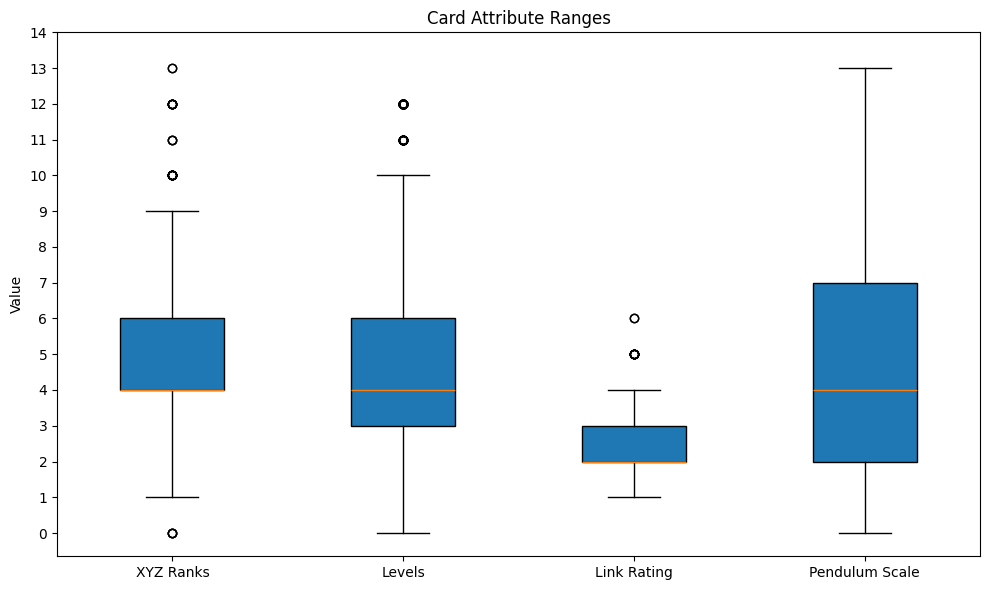

In [9]:
# Filter different monster types
xyz_monsters = ygo_tcg[ygo_tcg['type'] == 'XYZ Monster'] # =XYZ
non_xyz_monsters = ygo_tcg[ygo_tcg['type'] != 'XYZ Monster'] # =/= XYZ
link_monsters = ygo_tcg[ygo_tcg['type'] == 'Link Monster'] # = Link
pendulum_monsters = ygo_tcg[ygo_tcg['type'].str.contains('Pendulum', na=False)] # If missing, then false (final 'filter')

# Prep data for boxplots 
data_to_plot = [
    xyz_monsters['level'].dropna(), #Technically rank, but functionally identical to level so counted as such
    non_xyz_monsters['level'].dropna(), # Actual levls (stars on the cards)
    link_monsters['linkval'].dropna(), # Link arrow count (link-1 thru link-6)
    pendulum_monsters['scale'].dropna() # Scale of summoning on pendulum (0-13)
]

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, vert=True, patch_artist=True, tick_labels=['XYZ Ranks', 'Levels', 'Link Rating', 'Pendulum Scale'])

# Set the y-ticks to increase by 1 instead of by 2, just for visualization purposes (and it looks nice)
min_value = min([min(data) for data in data_to_plot])
max_value = max([max(data) for data in data_to_plot])
yticks = range(int(min_value), int(max_value) + 2, 1) 
plt.yticks(yticks)

plt.title('Card Attribute Ranges')
plt.ylabel('Value')
plt.tight_layout()
plt.show()


card_category
Monster    8250
Spell      2553
Trap       1911
Name: count, dtype: int64


C:\Users\Chenz\AppData\Local\Temp\ipykernel_22464\695236850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ygo_tcg['type'] = ygo_tcg['type'].str.strip()
C:\Users\Chenz\AppData\Local\Temp\ipykernel_22464\695236850.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ygo_tcg.loc[:, 'card_category'] = ygo_tcg['type'].apply(categorize_card_type)


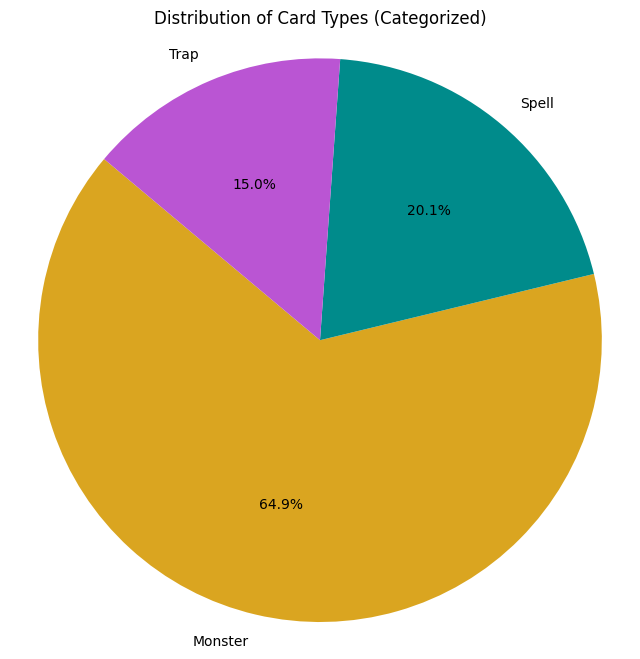

In [10]:
# Removes extra spaces or any discrepanceis in the types (I had an issue that this fixed for whatever reason so I'm not touching it)
ygo_tcg['type'] = ygo_tcg['type'].str.strip()

# Categorize cards into three categories (Monster, Spell, Trap)
def categorize_card_type(card_type):
    card_type = card_type.lower()  # Convert type to lowercase to ensure they're all the same
    if 'monster' in card_type:
        return 'Monster'
    elif 'spell' in card_type:
        return 'Spell'
    elif 'trap' in card_type:
        return 'Trap'
    else:
        return None  # If the card doesn't fit into any of these categories, it becomes none
# Apply categorization function to ygo_tcg
ygo_tcg.loc[:, 'card_category'] = ygo_tcg['type'].apply(categorize_card_type)
# Removes rows where card category is None (cards that don't fit into the 3 categories)
ygo_tcg = ygo_tcg.dropna(subset=['card_category'])

# Check count of each category to make sure it didn't mess up
print(ygo_tcg['card_category'].value_counts())  

# Count number of each
card_category_counts = ygo_tcg['card_category'].value_counts()

# Pie chart with correlating colors to the card types
plt.figure(figsize=(8, 8))
colors = ['goldenrod', 'darkcyan', 'mediumorchid']  # Colors for Monster, Spell, and Trap
plt.pie(card_category_counts, labels=card_category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Card Types (Categorized)")
plt.axis('equal')  
plt.show()


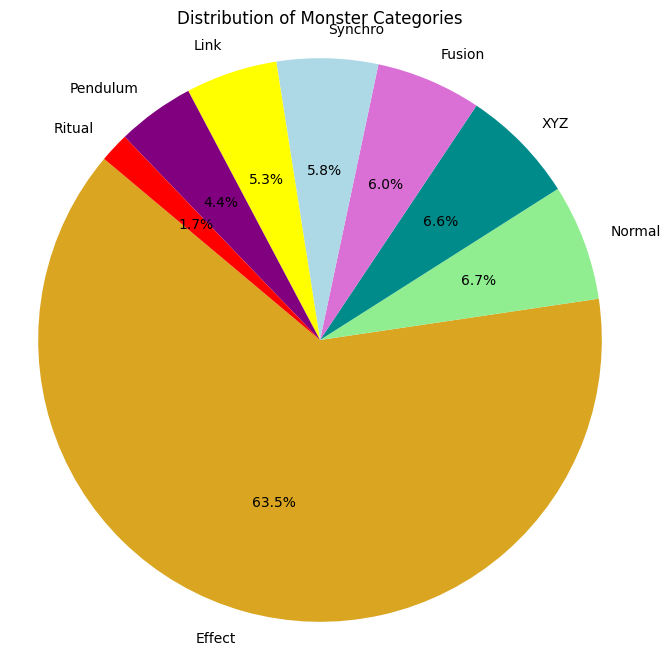

In [11]:
# Function to categorize monsters based on type
#This actually took me so long to figure out- I originally tried individually sorting each of the types into seprate categories and it went horribly
# I realized I was stupid and could just filter via 'type' in a function in order to just automatically do it for me... 
def categorize_monster(monster_type):
    # First check for the more specific categories
    if 'Pendulum' in monster_type:
        return 'Pendulum'
    elif 'XYZ' in monster_type:
        return 'XYZ'
    elif 'Synchro' in monster_type:
        return 'Synchro'
    elif 'Link' in monster_type:
        return 'Link'
    elif 'Fusion' in monster_type:
        return 'Fusion'
    elif 'Ritual' in monster_type:
        return 'Ritual'
    elif 'Effect' in monster_type:  # Effect monsters (but not other categories)
        return 'Effect'
    elif 'Normal' in monster_type:  # Normal monsters (only if not other categories)
        return 'Normal'
    else:
        return None  # If the card doesn't match any category, return None (spells/traps)

# Apply function to monsters
ygo_tcg.loc[:, 'monster_category'] = ygo_tcg['type'].apply(categorize_monster)

# Remove rows where monster category is None (spell/traps)
ygo_tcg = ygo_tcg.dropna(subset=['monster_category'])

# Count the number of each category
monster_category_counts = ygo_tcg['monster_category'].value_counts()

# Pie chart!
plt.figure(figsize=(8, 8))
colors = ['goldenrod', 'lightgreen', 'darkcyan', 'orchid', 'lightblue', 'yellow', 'purple', 'red']  # Colors for each category
plt.pie(monster_category_counts, labels=monster_category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Monster Categories")
plt.axis('equal')
plt.show()


In [12]:
# Filter exclusively Effect monsters (Effect but not in other categories)
exclusively_effect_monsters = ygo_tcg[(ygo_tcg['monster_category'] == 'Normal') &
                                      (~ygo_tcg['type'].str.contains('Pendulum|XYZ|Synchro|Link|Fusion|Ritual', na=False))]

# Calculate total number of monsters
total_monsters = ygo_tcg.shape[0]

# Calculate number of ONLY effect (and no other category) monsters
exclusively_effect_count = exclusively_effect_monsters.shape[0]

# Calculate %
percentage_exclusively_effect = (exclusively_effect_count / total_monsters) * 100


print(f"Percentage of exclusively Effect Monsters: {percentage_exclusively_effect:.2f}%")

#Just to double check that I am actually right and the pie chart didn't include overlapping cards
# Yay it worked!

Percentage of exclusively Effect Monsters: 6.66%


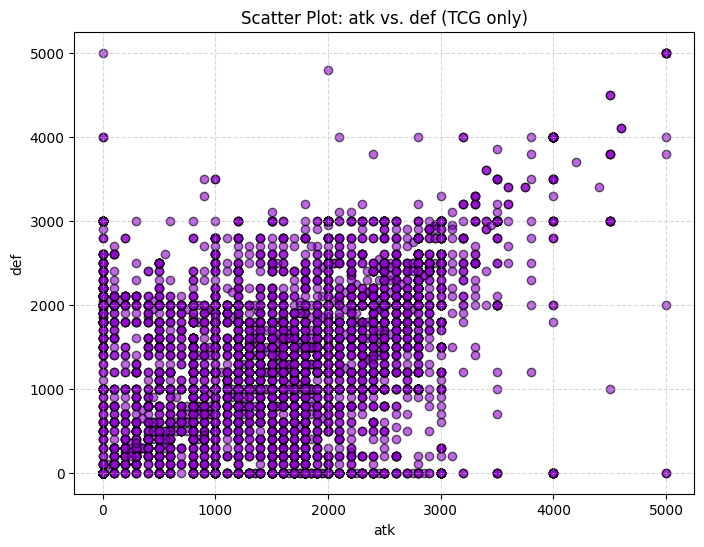

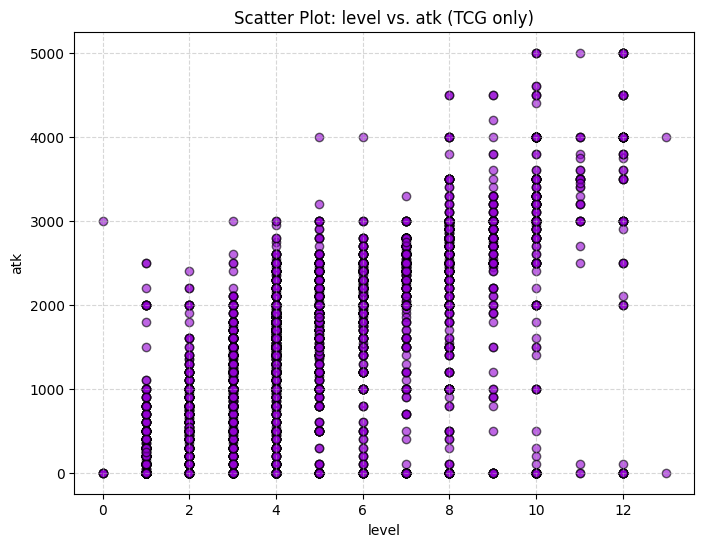

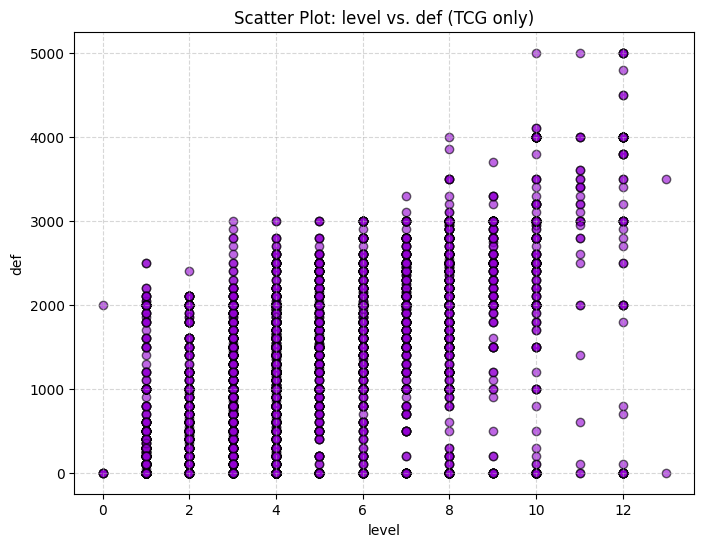

In [13]:
# Numerical columns comparison
pairs = [('atk', 'def'), ('level', 'atk'), ('level', 'def')]


# For loop to compare all of them because I am lazy and don't want to make multiple graphs
for x_col, y_col in pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(ygo_tcg[x_col], ygo_tcg[y_col], alpha=0.6, color='darkviolet', edgecolor='k')
    plt.title(f"Scatter Plot: {x_col} vs. {y_col} (TCG only)")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()


In [14]:
for x_col, y_col in pairs:
    # Drop rows with missing values for the pair
    data = ygo_tcg[[x_col, y_col]].dropna()
    
    # Pearson correlation
    pearson_corr, p_value_pearson = pearsonr(data[x_col], data[y_col])
    print(f"Pearson correlation between {x_col} and {y_col}: {pearson_corr:.3f} (p-value: {p_value_pearson:.3e})")
    
    # Spearman correlation
    spearman_corr, p_value_spearman = spearmanr(data[x_col], data[y_col])
    print(f"Spearman correlation between {x_col} and {y_col}: {spearman_corr:.3f} (p-value: {p_value_spearman:.3e})\n")

# Did not learn in class (spearman at least)

Pearson correlation between atk and def: 0.478 (p-value: 0.000e+00)
Spearman correlation between atk and def: 0.437 (p-value: 0.000e+00)

Pearson correlation between level and atk: 0.707 (p-value: 0.000e+00)
Spearman correlation between level and atk: 0.726 (p-value: 0.000e+00)

Pearson correlation between level and def: 0.569 (p-value: 0.000e+00)
Spearman correlation between level and def: 0.546 (p-value: 0.000e+00)



In [15]:
# Perform KS test for numerical pair (atk and def)
ks_stat, p_value_ks = ks_2samp(ygo_tcg['atk'].dropna(), ygo_tcg['def'].dropna())
print(f"KS Test: atk vs. def")
print(f"Statistic: {ks_stat:.3f}, p-value: {p_value_ks:.3e}")

# Did not learn in class

KS Test: atk vs. def
Statistic: 0.128, p-value: 8.195e-54


In [16]:
# List of categorical pairs
categorical_pairs = [
    ('type', 'race'),
    ('archetype', 'ban_tcg'),
    ('archetype', 'ban_ocg'),
    ('archetype', 'type')  
]

# Loop through the pairs for Chi-Squared tests (I love my for loops)
for var1, var2 in categorical_pairs:
    # Create contingency table
    contingency_table = pd.crosstab(ygo_tcg[var1], ygo_tcg[var2])
    
    # Perform Chi-Squared test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Output the result
    print(f"Chi-Squared Test: {var1} vs. {var2}")
    print(f"Chi2 Stat: {chi2_stat:.3f}, p-value: {p_value:.3e}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies: \n{expected}\n")

#This is way too long and I can barely make out the results, time to make it better in the next cell

Chi-Squared Test: type vs. race
Chi2 Stat: 1792.995, p-value: 1.588e-157
Degrees of Freedom: 456
Expected Frequencies: 
[[1.40004547e+02 2.16370664e+02 1.41216708e+02 1.57580876e+02
  7.69721970e+01 3.03040146e+00 3.98194751e+02 2.99403664e+02
  4.51529817e+02 7.57600364e+01 1.21216058e+01 1.44853190e+02
  5.29714174e+02 1.27276861e+02 9.63667663e+01 8.06086787e+01
  1.00003248e+02 1.43641029e+02 4.48499415e+01 3.84254905e+02
  7.51539561e+01 6.15777576e+02 1.70308562e+02 5.15168247e+01
  1.28489022e+02]
 [5.49213979e+00 8.48785241e+00 5.53969079e+00 6.18162921e+00
  3.01948811e+00 1.18877485e-01 1.56205015e+01 1.17450955e+01
  1.77127452e+01 2.97193712e+00 4.75509939e-01 5.68234377e+00
  2.07797843e+01 4.99285436e+00 3.78030401e+00 3.16214109e+00
  3.92295700e+00 5.63479278e+00 1.75938677e+00 1.50736651e+01
  2.94816162e+00 2.41559049e+01 6.68091464e+00 2.02091724e+00
  5.04040535e+00]
 [1.39554372e+01 2.15674938e+01 1.40762635e+01 1.57074185e+01
  7.67246979e+00 3.02065740e-01 3.9691

In [17]:
# pt 2? ish??

# List of categorical pairs
categorical_pairs = [
    ('type', 'race'), # Card type vs "race" (the thingy that says what specific type of card it is)
    ('archetype', 'race'), # Card Type vs archetype
    ('archetype', 'attribute'), # Archetype vs Attribute
    ('archetype', 'type')  # Archetype vs Type
]

# Loop through pairs for Chi-Squared tests
for var1, var2 in categorical_pairs:
    # Create contingency table
    contingency_table = pd.crosstab(ygo_tcg[var1], ygo_tcg[var2])
    
    # Perform Chi-Squared test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Output
    print(f"Chi-Squared Test: {var1} vs. {var2}")
    print(f"Chi2 Stat: {chi2_stat:.3f}, p-value: {p_value:.3e}")
    print(f"Degrees of Freedom: {dof}")
    
    #Got rid of expected frequencies because it's just extra stuff I have to scroll past if I'm being honest

    # Interpret p-value (google says <0.05 shows association)
    if p_value < 0.05:
        print("Result: Statistically significant (reject null hypothesis)\n")
    else:
        print("Result: Not statistically significant (fail to reject null hypothesis)\n")

Chi-Squared Test: type vs. race
Chi2 Stat: 1792.995, p-value: 1.588e-157
Degrees of Freedom: 456
Result: Statistically significant (reject null hypothesis)

Chi-Squared Test: archetype vs. race
Chi2 Stat: 72950.972, p-value: 0.000e+00
Degrees of Freedom: 11736
Result: Statistically significant (reject null hypothesis)

Chi-Squared Test: archetype vs. attribute
Chi2 Stat: 17304.692, p-value: 0.000e+00
Degrees of Freedom: 2934
Result: Statistically significant (reject null hypothesis)

Chi-Squared Test: archetype vs. type
Chi2 Stat: 23099.207, p-value: 0.000e+00
Degrees of Freedom: 9291
Result: Statistically significant (reject null hypothesis)



In [18]:
# Keep only rows where type contains 'Monster' (ignoring tokens, spells, traps, etc)
ygo_tcg_monsters = ygo_tcg[ygo_tcg['type'].str.contains('Monster')]

# Verify that the filtering actually worked
print(ygo_tcg_monsters['type'].unique())  # Should only show 'Monster' related types
print(ygo_tcg_monsters.shape)  # Check the size of the filtered dataset



['Effect Monster' 'Flip Effect Monster' 'Normal Monster'
 'Union Effect Monster' 'Fusion Monster' 'Pendulum Effect Monster'
 'Link Monster' 'XYZ Monster' 'Synchro Monster' 'Synchro Tuner Monster'
 'Normal Tuner Monster' 'Ritual Effect Monster'
 'Pendulum Effect Fusion Monster' 'Ritual Monster'
 'Pendulum Normal Monster' 'Synchro Pendulum Effect Monster'
 'Pendulum Tuner Effect Monster' 'XYZ Pendulum Effect Monster'
 'Pendulum Effect Ritual Monster' 'Pendulum Flip Effect Monster']
(7697, 31)


In [19]:
# Define X & Y
X = ygo_tcg_monsters[['race', 'attribute', 'type', 'name', 'level', 'atk', 'def']]
y = ygo_tcg_monsters['archetype']

# Encode categorical variables
X_encoded = pd.get_dummies(X)
y_encoded = y.astype('category').cat.codes

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)

# Make prediction
y_pred = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Did not learn in class (at least this specific type of machine learning)
# Was the most accurate that I tried for my X/Y, so we're getting somewhere...
# As a professional player, I know there is a major correlation for some archetypes but not enough to encompass the whole TCG

Accuracy: 0.43116883116883115
Classification Report:
               precision    recall  f1-score   support

          -1       0.42      0.91      0.58       548
           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         4
           3       0.60      0.75      0.67         4
           4       0.29      0.67      0.40         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00    

C:\Users\Chenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:15

In [20]:
# Define X & Y
X = ygo_tcg_monsters[['race', 'attribute', 'type', 'name']]
y = ygo_tcg_monsters['archetype']

# Encode categorical variables
X_encoded = pd.get_dummies(X)
y_encoded = y.astype('category').cat.codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Train Logistic Regression classifier
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Make prediction
y_pred = logreg_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))

#There is not a be-all-end-all pattern, only between archetypes unfortunately...


Accuracy: 0.39675324675324675


In [23]:
# Remove rows where level is empty
ygo_tcg_monsters_filtered = ygo_tcg_monsters.dropna(subset=['level'])

# Define X & Y
X = ygo_tcg_monsters_filtered[['atk', 'def']]
y = ygo_tcg_monsters_filtered['level']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Make prediction
y_pred = rf_regressor.predict(X_test)

# Round predictions to the nearest integer for exact match accuracy
y_pred_rounded = y_pred.round()

# Calculate exact match %
exact_accuracy = (y_pred_rounded == y_test).mean() * 100

# Calculate accuracy within ±1
accuracy_within_1 = (abs(y_pred - y_test) <= 1).mean() * 100

print(f"Random Forest Regression Exact Accuracy: {exact_accuracy:.2f}%")
print(f"Random Forest Regression Accuracy within ±1: {accuracy_within_1:.2f}%")


Random Forest Regression Exact Accuracy: 45.78%
Random Forest Regression Accuracy within ±1: 71.35%
